# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

In [2]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE


plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [3]:
opt = {
    'image_size': 32,
    'is_grayscale': True,
    'val_split': 0.75
}

### Load Dataset

In [4]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [5]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (400, 32, 32)


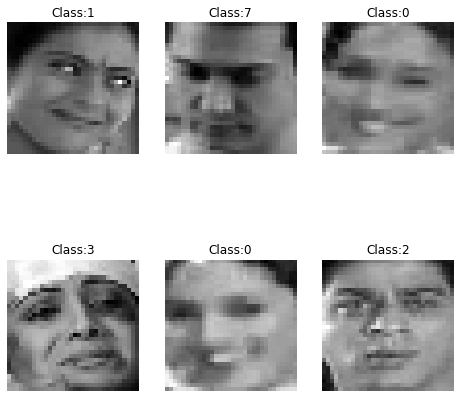

In [6]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

In [7]:
dirpath = './dataset/IIIT-CFW/'
X_1,y_1 = load_data(dirpath)
N_1,H_1,W_1 = X_1.shape[0:3]
C = 1 if opt['is_grayscale'] else X_1.shape[3]

Dataset shape: (672, 32, 32)


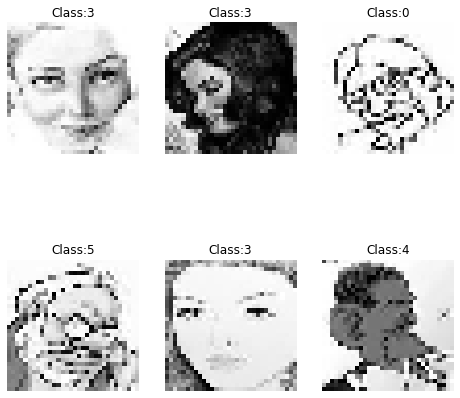

In [8]:
# Show sample images
ind = np.random.randint(0,y_1.shape[0],6)
disply_images(X_1[ind,...],y_1[ind], row=2,col=3)

In [9]:
dirpath = './dataset/Yale_face_database/'
X_2,y_2 = load_data(dirpath)
N_2,H_2,W_2 = X_2.shape[0:3]
C = 1 if opt['is_grayscale'] else X_2.shape[3]

Dataset shape: (165, 32, 32)


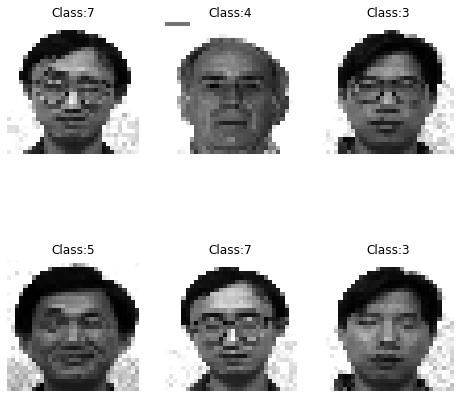

In [10]:
# Show sample images
ind = np.random.randint(0,y_2.shape[0],6)
disply_images(X_2[ind,...],y_2[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [11]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [12]:
X_1 = X_1.reshape((N_1,H_1*W_1*C))

In [13]:
X_2 = X_2.reshape((N_2,H_2*W_2*C))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [14]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [15]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [16]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [17]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X_transformed,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [18]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [19]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________

Your answers here (double click to edit)
Eigenfaces is a name given to eigenvectors in the domain of computer vision. These can help us know to what dimension we can reduce the image so that we can compress but at the same time not reduce its quality significantly.  


1(b). How many eigen vectors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples and make a convincing argument.

## IMFDB 
Number of eigenvectors is around 108. 
## IIIT-CFW
Number of eigenvectors is around 309.
## Yale Face Database 
Number of eigenvectors is around 62.

I have plotted the spectrum for reference. One can notice that there is a significant drop (and the rest are almost negligible) at the above mentioned numbers. I have taken the threshold value as 0.95 for eigenvalues selected divided by total eigenvalues.    

In [20]:
# Compute your features 
# eg.
# X_3D = get_kernel_lda(X,y,3)
#loading dataset 
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
print(np.shape(X))
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
cov = np.cov(X.T) #check 
print(np.shape(cov))
eigvals, eigvectors = np.linalg.eig(cov) 
# print(np.shape(eigvals))
s_vals = eigvals[:2]
s_vecs = eigvectors[:, :2]
print(X.shape[1])
X_k = np.dot(s_vecs.T, X.T).T
# print(X_k)
# for i in range(X.shape[1]):
#     s_vals = eigvals[:i]
#     s_vecs = eigvectors[:, :i]
#     X_k = np.dot(s_vecs.T, X.T).T
#     print(i, np.sum(s_vals)/full)  #check explained_variance_
    
s_vals = eigvals[:108]
s_vecs = eigvectors[:, :108]
X_k = np.dot(s_vecs.T, X.T).T
print(np.shape(X_k))
#X = get_pca(X, 3)


Dataset shape: (400, 32, 32)
(400, 32, 32)
(1024, 1024)
1024
(400, 108)


In [21]:
dirpath = './dataset/IIIT-CFW/'
X_1,y_1 = load_data(dirpath)
N,H,W = X_1.shape[0:3]
print(np.shape(X_1))
C = 1 if opt['is_grayscale'] else X_1.shape[3]
X_1 = X_1.reshape((N,H*W*C))
print(X_1.shape[1])
cov_1 = np.cov(X_1.T) #check 
# print(np.shape(cov_1))
eigvals_1, eigvectors_1 = np.linalg.eig(cov_1) 
full_1 = np.sum(np.real(eigvals_1))
# for i in range(X_1.shape[1]):
#     s_vals_1 = eigvals_1[:i]
#     s_vecs_1 = eigvectors_1[:, :i]
#     X_k_1 = np.dot(s_vecs_1.T, X_1.T).T
#     print(i, np.sum(np.real(s_vals_1))/full_1) 

s_vals_1 = eigvals_1[:309]
s_vecs_1 = eigvectors_1[:, :309]

X_k_1 = np.dot(s_vecs_1.T, X_1.T).T
# print(np.shape(X_k_1))
# magic number 309
    

Dataset shape: (672, 32, 32)
(672, 32, 32)
1024


In [22]:
dirpath = './dataset/Yale_face_database/'
X_2,y_2 = load_data(dirpath)
print(np.shape(X_2))
N,H,W = X_2.shape[0:3]
C = 1 if opt['is_grayscale'] else X_2.shape[3]
X_2 = X_2.reshape((N,H*W*C))
print(X_2.shape[1])
cov_2 = np.cov(X_2.T) #check 
# print(np.shape(cov))
eigvals_2, eigvectors_2 = np.linalg.eig(cov_2) 
full_2 = np.sum(np.real(eigvals_2))
# for i in range(X_2.shape[1]):
#     s_vals_2 = eigvals_2[:i]
#     s_vecs_2 = eigvectors_2[:, :i]
#     X_k_2 = np.dot(s_vecs_2.T, X_2.T).T
#     print(i, np.sum(np.real(s_vals_2))/full_2) 

s_vals_2 = eigvals_2[:62]
s_vecs_2 = eigvectors_2[:, :62]

X_k_2 = np.dot(s_vecs_2.T, X_2.T).T

Dataset shape: (165, 32, 32)
(165, 32, 32)
1024


(400,)


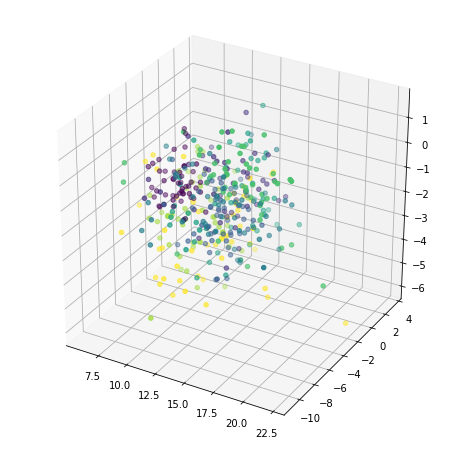

In [23]:
# Create a scatter plot  
# eg.
print(np.shape(np.real(X_k[:,0])))
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.real(X_k[:,0]),np.real(X_k[:,1]), np.real(X_k[:,2]), c=y)

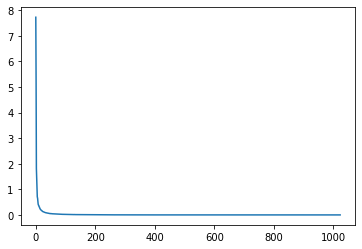

In [24]:
# Plot the eigen value spectrum 
# s_vals = eigvals[:1024]
# s_vecs = eigvectors[:, :1024]
X_k = np.dot(eigvals.T, X.T).T
plt.plot(np.real(eigvals))

s_vals = eigvals[:108]
s_vecs = eigvectors[:, :108]
X_k = np.dot(s_vecs.T, X.T).T
# need for next cell. Perfect dimension to reduce is 108. It is above 95% 
# pca = get_pca(X, 109) 
# X_k = pca.fit_transform(X)

(672, 1024)


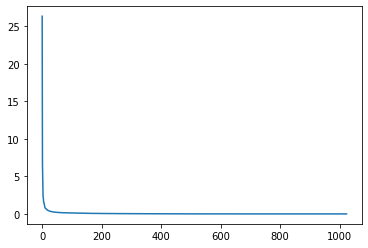

In [25]:
print(np.shape(X_1))
# s_vals_1 = eigvals_1[:3072]
# s_vecs_1 = eigvectors_1[:, :3072]
X_k_1 = np.dot(eigvals_1.T, X_1.T).T
plt.plot(np.real(eigvals_1))

s_vals_1 = eigvals_1[:309]
s_vecs_1 = eigvectors_1[:, :309]
X_k_1 = np.dot(s_vecs_1.T, X_1.T).T

(165, 1024)


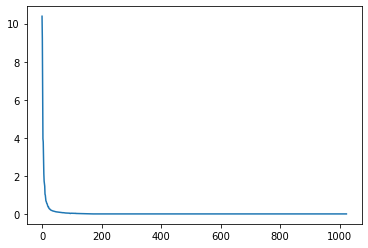

In [26]:
print(np.shape(X_2))
s_vals_2 = eigvals_2[:3072]
s_vecs_2 = eigvectors_1[:, :3072]
X_k_2 = np.dot(s_vecs_2.T, X_2.T).T
plt.plot(np.real(s_vals_2))

s_vals_2 = eigvals_2[:62]
s_vecs_2 = eigvectors_2[:, :62]
X_k_2 = np.dot(s_vecs_2.T, X_2.T).T

1(c). Reconstruct  the  image  back for each case


In [27]:
def reconstruct_images(eigenvectors, X_k):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
#     reconstruct_X = pca.inverse_transform(X_k)
#     data_recovered = NP.dot(eigenvectors, m).T
    reconstruct_X = np.dot(eigenvectors, X_k).T
    
    return reconstruct_X    

In [28]:
# Display results 
X_reconstructed = reconstruct_images(s_vecs, X_k.T)
# print(np.shape(X_reconstructed))
# ind = np.random.randint(0,y.shape[0],6)
# disply_images(X[ind,...],y[ind], row=2,col=3)

# Display random images
# ind = np.random.randint(0,y.shape[0],6)
# disply_images(X_reconstruced[ind,...],y[ind],row=2,col=3)

# Show the reconstruction error
print(np.sqrt(np.mean((X - X_reconstructed)**2)))

(0.04023024649167747+0j)


In [29]:
X_reconstructed_1 = reconstruct_images(s_vecs_1, X_k_1.T)
# print(np.shape(X_reconstructed))
# ind = np.random.randint(0,y.shape[0],6)
# disply_images(X[ind,...],y[ind], row=2,col=3)

# Display random images
# ind = np.random.randint(0,y.shape[0],6)
# disply_images(X_reconstruced[ind,...],y[ind],row=2,col=3)

# Show the reconstruction error
print(np.sqrt(np.mean((X_1 - X_reconstructed_1)**2)))

(0.06426838393868956+0j)


In [30]:
X_reconstructed_2 = reconstruct_images(s_vecs_2, X_k_2.T)
# print(np.shape(X_reconstructed))
# ind = np.random.randint(0,y.shape[0],6)
# disply_images(X[ind,...],y[ind], row=2,col=3)

# Display random images
# ind = np.random.randint(0,y.shape[0],6)
# disply_images(X_reconstruced[ind,...],y[ind],row=2,col=3)

# Show the reconstruction error
print(np.sqrt(np.mean((X_2 - X_reconstructed_2)**2)))

(0.1404954791875422+0j)


1(d). Which person/identity is difficult to represent compactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

## IMFDB 
Madhuri is the most difficult person to respresent with fewer eigenvectors when compared with others. She probably has complex facial faetures which needs more eigenvectors to express/represent. 
## IIIT-CFW 
Man Mohan Singh is the most difficult person to respresent with fewer eigenvectors when compared with others. He probably has complex facial faetures which needs more eigenvectors to express/represent.  
## Yale Face Database
Class 0 is slightly harder to represent with fewer eigenvectors when compared with others.  

In [31]:
# code goes here
classes = {}
# classes[0] = X[np.where(y==0)]
for i in range(8):
    classes[i] = X[np.where(y==i)]

cov = np.cov(classes[7].T) #check 
eigvals, eigvectors = np.linalg.eig(cov) 
full = np.sum(np.real(eigvals[:1024]))
# for i in range(classes[4].shape[1]):
#     s_vals = eigvals[:i]
#     s_vecs = eigvectors[:, :i]
#     X_k = np.dot(s_vecs.T, X.T).T
#     print(i, np.sum(np.real(s_vals))/full) 
# print(X_k)
#class0 - 35 - Madhuri - Complex Facial Features. 
#class1 - 31
#class2 - 33
#class3 - 30
#class4 - 31
#class5 - 27 - Katrina Kaif - Simple face. Easily Representable with fewer eigen faces 
#class6 - 32
#class7 - 29

In [32]:
classes_1 = {}
for i in range(8):
    classes_1[i] =(X_1[np.where(y_1==i)])
    print(classes_1[i].shape)

(50, 1024)
(42, 1024)
(79, 1024)
(101, 1024)
(100, 1024)
(100, 1024)
(100, 1024)
(100, 1024)


In [33]:
# print(np.shape(X_1[np.where(y_1==3)]))
cov_1 = np.cov(classes_1[7].T) #check 
eigvals_1, eigvectors_1 = np.linalg.eig(cov_1) 
full_1 = np.sum(np.real(eigvals_1))
# for i in range(classes_1[1].shape[1]):
#     s_vals_1 = eigvals_1[:i]
#     s_vecs_1 = eigvectors_1[:, :i]
#     X_k_1 = np.dot(s_vecs_1.T, X_1.T).T
#     print(i, np.sum(np.real(s_vals_1))/full_1) 
    
# class0 - 33
# class1 - 33
# class2 - 49 
# class3 - 65
# class4 - 71
# class5 - 79
# class6 - 77
# class7 - 73

In [34]:
classes_2 = {}
for i in range(8):
    classes_2[i] =(X_2[np.where(y_2==i)])

In [35]:
cov_2 = np.cov(classes_2[0].T) #check 
eigvals_2, eigvectors_2 = np.linalg.eig(cov_2) 
full_2 = np.sum(np.real(eigvals_2))
# for i in range(classes_2[1].shape[1]):
#     s_vals_2 = eigvals_2[:i]
#     s_vecs_2 = eigvectors_2[:, :i]
#     X_k_2 = np.dot(s_vecs_2.T, X_2.T).T
#     print(i, np.sum(np.real(s_vals_2))/full_2) 

#class7 - 8
#class6 - 7
#class5 - 7 
#class4 - 7 
#class3 - 7 
#class2 - 7
#class1 - 7 
#class0 - 7

2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b) Which method works well? Do a comparitivestudy. 

In my opinion, out of the 6 combinations that I have tried, Resnet + LDA + MLP works best with all the datasets given. 

You already know the paper [Face Recognition Using  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [36]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
# MLP
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
import sklearn as sk
class Classifier():
    def __init__(self, X_train):
#         super.__init__()
        model = Sequential()
        model.add(Dense(35, input_dim=X_train.shape[1], activation='relu'))# layer 1 neuron 1000
        model.add(Dense(35, activation='relu'))# layer 2 neuron 1000
        model.add(Dense(8, activation='sigmoid'))# output layer
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model = model
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        predict = model.predict(X)
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        confusion_matrix = sk.metrics.confusion_matrix(y, pred)
        return confusion_matrix
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.model.fit(X_train, y_train,epochs=100)
        
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        y_pred = self.model.predict_classes(X_validate)
        # Create a confusion matrix
        confusion_matrix = self.confusion_matrix(y_pred, y_validate)
        # Calculate Validation accuracy 
        # Calculate precision and recall 
        # Calculate F1-score 
        target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6',  'class 7']
        classification_report = sk.metrics.classification_report(y_validate, y_pred, target_names=target_names)
        return confusion_matrix, classification_report

Using TensorFlow backend.


In [37]:
# Create a train and validation split to train your classifier 
#PCA + MLP (1)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_pca(X,108)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (400, 32, 32)
Epoch 1/100
320/320 [==============================] - 0s 375us/step - loss: 2.0989 - accuracy: 0.1187
Epoch 2/100
320/320 [==============================] - 0s 53us/step - loss: 2.0423 - accuracy: 0.2375
Epoch 3/100
320/320 [==============================] - 0s 51us/step - loss: 1.9974 - accuracy: 0.3406
Epoch 4/100
320/320 [==============================] - 0s 53us/step - loss: 1.9570 - accuracy: 0.4094
Epoch 5/100
320/320 [==============================] - 0s 53us/step - loss: 1.9144 - accuracy: 0.4563
Epoch 6/100
320/320 [==============================] - 0s 53us/step - loss: 1.8711 - accuracy: 0.4719
Epoch 7/100
320/320 [==============================] - 0s 55us/step - loss: 1.8228 - accuracy: 0.4844
Epoch 8/100
320/320 [==============================] - 0s 51us/step - loss: 1.7669 - accuracy: 0.5094
Epoch 9/100
320/320 [==============================] - 0s 57us/step - loss: 1.7041 - accuracy: 0.5531
Epoch 10/100
320/320 [==============================

320/320 [==============================] - 0s 39us/step - loss: 0.0089 - accuracy: 1.0000
Epoch 81/100
320/320 [==============================] - 0s 40us/step - loss: 0.0087 - accuracy: 1.0000
Epoch 82/100
320/320 [==============================] - 0s 38us/step - loss: 0.0084 - accuracy: 1.0000
Epoch 83/100
320/320 [==============================] - 0s 39us/step - loss: 0.0081 - accuracy: 1.0000
Epoch 84/100
320/320 [==============================] - 0s 44us/step - loss: 0.0079 - accuracy: 1.0000
Epoch 85/100
320/320 [==============================] - 0s 43us/step - loss: 0.0076 - accuracy: 1.0000
Epoch 86/100
320/320 [==============================] - 0s 40us/step - loss: 0.0074 - accuracy: 1.0000
Epoch 87/100
320/320 [==============================] - 0s 40us/step - loss: 0.0072 - accuracy: 1.0000
Epoch 88/100
320/320 [==============================] - 0s 38us/step - loss: 0.0070 - accuracy: 1.0000
Epoch 89/100
320/320 [==============================] - 0s 40us/step - loss: 0.0068 - 

In [38]:
# Create a train and validation split to train your classifier 
# LDA + MLP (2)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_lda(X,y,7)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (400, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Epoch 1/100
320/320 [==============================] - 0s 347us/step - loss: 2.0063 - accuracy: 0.1969
Epoch 2/100
320/320 [==============================] - 0s 50us/step - loss: 1.7542 - accuracy: 0.3594
Epoch 3/100
320/320 [==============================] - 0s 48us/step - loss: 1.5606 - accuracy: 0.5375
Epoch 4/100
320/320 [==============================] - 0s 55us/step - loss: 1.3837 - accuracy: 0.7250
Epoch 5/100
320/320 [==============================] - 0s 50us/step - loss: 1.2125 - accuracy: 0.8406
Epoch 6/100
320/320 [==============================] - 0s 52us/step - loss: 1.0364 - accuracy: 0.9000
Epoch 7/100
320/320 [==============================] - 0s 52us/step - loss: 0.8567 - accuracy: 0.9344
Epoch 8/100
320/320 [==============================] - 0s 55us/step - loss: 0.6787 - accuracy: 0.9500
Epoch 9/100
320/320 [==============================] - 0s 55us/step - loss: 0.5154 - accuracy: 0.9563
Epoch 10/100
320/320 [==============================] - 0s 54us/step - loss: 0.38

320/320 [==============================] - 0s 39us/step - loss: 0.0077 - accuracy: 1.0000
Epoch 81/100
320/320 [==============================] - 0s 43us/step - loss: 0.0075 - accuracy: 1.0000
Epoch 82/100
320/320 [==============================] - 0s 44us/step - loss: 0.0073 - accuracy: 1.0000
Epoch 83/100
320/320 [==============================] - 0s 42us/step - loss: 0.0071 - accuracy: 1.0000
Epoch 84/100
320/320 [==============================] - 0s 41us/step - loss: 0.0070 - accuracy: 1.0000
Epoch 85/100
320/320 [==============================] - 0s 40us/step - loss: 0.0067 - accuracy: 1.0000
Epoch 86/100
320/320 [==============================] - 0s 40us/step - loss: 0.0066 - accuracy: 1.0000
Epoch 87/100
320/320 [==============================] - 0s 39us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 88/100
320/320 [==============================] - 0s 41us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 89/100
320/320 [==============================] - 0s 40us/step - loss: 0.0061 - 

In [39]:
# KLDA + MLP (3)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_kernel_lda(X,y,7)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (400, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Epoch 1/100
320/320 [==============================] - 0s 356us/step - loss: 2.2969 - accuracy: 0.1187
Epoch 2/100
320/320 [==============================] - 0s 47us/step - loss: 1.9449 - accuracy: 0.2250
Epoch 3/100
320/320 [==============================] - 0s 49us/step - loss: 1.7427 - accuracy: 0.2875
Epoch 4/100
320/320 [==============================] - 0s 51us/step - loss: 1.5991 - accuracy: 0.3906
Epoch 5/100
320/320 [==============================] - 0s 48us/step - loss: 1.4623 - accuracy: 0.6594
Epoch 6/100
320/320 [==============================] - 0s 49us/step - loss: 1.3156 - accuracy: 0.8094
Epoch 7/100
320/320 [==============================] - 0s 51us/step - loss: 1.1462 - accuracy: 0.8906
Epoch 8/100
320/320 [==============================] - 0s 53us/step - loss: 0.9508 - accuracy: 0.9406
Epoch 9/100
320/320 [==============================] - 0s 52us/step - loss: 0.7650 - accuracy: 0.9469
Epoch 10/100
320/320 [==============================] - 0s 57us/step - loss: 0.59

320/320 [==============================] - 0s 40us/step - loss: 0.0134 - accuracy: 0.9969
Epoch 81/100
320/320 [==============================] - 0s 41us/step - loss: 0.0130 - accuracy: 0.9969
Epoch 82/100
320/320 [==============================] - 0s 41us/step - loss: 0.0127 - accuracy: 0.9969
Epoch 83/100
320/320 [==============================] - 0s 40us/step - loss: 0.0123 - accuracy: 0.9969
Epoch 84/100
320/320 [==============================] - 0s 40us/step - loss: 0.0124 - accuracy: 0.9969
Epoch 85/100
320/320 [==============================] - 0s 41us/step - loss: 0.0118 - accuracy: 0.9969
Epoch 86/100
320/320 [==============================] - 0s 41us/step - loss: 0.0115 - accuracy: 0.9969
Epoch 87/100
320/320 [==============================] - 0s 40us/step - loss: 0.0113 - accuracy: 0.9969
Epoch 88/100
320/320 [==============================] - 0s 40us/step - loss: 0.0111 - accuracy: 0.9969
Epoch 89/100
320/320 [==============================] - 0s 40us/step - loss: 0.0107 - 

In [40]:
# VGG + MLP (4)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_vgg_features(dirpath)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (400, 32, 32)
Epoch 1/100
320/320 [==============================] - 0s 408us/step - loss: 1.7288 - accuracy: 0.4812
Epoch 2/100
320/320 [==============================] - 0s 114us/step - loss: 1.2999 - accuracy: 0.6344
Epoch 3/100
320/320 [==============================] - 0s 106us/step - loss: 0.8077 - accuracy: 0.6844
Epoch 4/100
320/320 [==============================] - 0s 101us/step - loss: 0.4858 - accuracy: 0.7563
Epoch 5/100
320/320 [==============================] - 0s 100us/step - loss: 0.3709 - accuracy: 0.7781
Epoch 6/100
320/320 [==============================] - 0s 94us/step - loss: 0.3533 - accuracy: 0.7906
Epoch 7/100
320/320 [==============================] - 0s 95us/step - loss: 0.4096 - accuracy: 0.7844
Epoch 8/100
320/320 [==============================] - 0s 96us/step - loss: 0.3287 - accuracy: 0.7875
Epoch 9/100
320/320 [==============================] - 0s 103us/step - loss: 0.3241 - accuracy: 0.7937
Epoch 10/100
320/320 [=========================

320/320 [==============================] - 0s 92us/step - loss: 0.1109 - accuracy: 0.9594
Epoch 81/100
320/320 [==============================] - 0s 94us/step - loss: 0.1194 - accuracy: 0.9531
Epoch 82/100
320/320 [==============================] - 0s 90us/step - loss: 0.1124 - accuracy: 0.9563
Epoch 83/100
320/320 [==============================] - 0s 83us/step - loss: 0.1203 - accuracy: 0.9500
Epoch 84/100
320/320 [==============================] - 0s 81us/step - loss: 0.1106 - accuracy: 0.9500
Epoch 85/100
320/320 [==============================] - 0s 80us/step - loss: 0.1123 - accuracy: 0.9594
Epoch 86/100
320/320 [==============================] - 0s 81us/step - loss: 0.1031 - accuracy: 0.9625
Epoch 87/100
320/320 [==============================] - 0s 80us/step - loss: 0.0996 - accuracy: 0.9563
Epoch 88/100
320/320 [==============================] - 0s 82us/step - loss: 0.1018 - accuracy: 0.9594
Epoch 89/100
320/320 [==============================] - 0s 85us/step - loss: 0.0896 - 

In [41]:
# Resnet + MLP (5)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_resnet_features(dirpath)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (400, 32, 32)
Epoch 1/100
320/320 [==============================] - 0s 396us/step - loss: 1.6294 - accuracy: 0.3313
Epoch 2/100
320/320 [==============================] - 0s 74us/step - loss: 0.8765 - accuracy: 0.7781
Epoch 3/100
320/320 [==============================] - 0s 76us/step - loss: 0.2807 - accuracy: 0.9656
Epoch 4/100
320/320 [==============================] - 0s 71us/step - loss: 0.1225 - accuracy: 0.9750
Epoch 5/100
320/320 [==============================] - 0s 71us/step - loss: 0.0903 - accuracy: 0.9812
Epoch 6/100
320/320 [==============================] - 0s 72us/step - loss: 0.0752 - accuracy: 0.9781
Epoch 7/100
320/320 [==============================] - 0s 71us/step - loss: 0.0623 - accuracy: 0.9875
Epoch 8/100
320/320 [==============================] - 0s 72us/step - loss: 0.0546 - accuracy: 0.9906
Epoch 9/100
320/320 [==============================] - 0s 68us/step - loss: 0.0487 - accuracy: 0.9906
Epoch 10/100
320/320 [==============================

320/320 [==============================] - 0s 77us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 81/100
320/320 [==============================] - 0s 74us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 82/100
320/320 [==============================] - 0s 63us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 83/100
320/320 [==============================] - 0s 62us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 84/100
320/320 [==============================] - 0s 62us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 85/100
320/320 [==============================] - 0s 65us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 86/100
320/320 [==============================] - 0s 61us/step - loss: 9.8300e-04 - accuracy: 1.0000
Epoch 87/100
320/320 [==============================] - 0s 69us/step - loss: 9.5132e-04 - accuracy: 1.0000
Epoch 88/100
320/320 [==============================] - 0s 63us/step - loss: 9.3697e-04 - accuracy: 1.0000
Epoch 89/100
320/320 [==============================] - 0s 61us/step - los

In [42]:
# Resnet + LDA + MLP (6)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_resnet_features(dirpath)
X = get_lda(X,y,108)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (400, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(2048, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Epoch 1/100
320/320 [==============================] - 0s 363us/step - loss: 1.9565 - accuracy: 0.2688
Epoch 2/100
320/320 [==============================] - 0s 65us/step - loss: 1.6687 - accuracy: 0.4437
Epoch 3/100
320/320 [==============================] - 0s 50us/step - loss: 1.4395 - accuracy: 0.6562
Epoch 4/100
320/320 [==============================] - 0s 48us/step - loss: 1.2284 - accuracy: 0.8062
Epoch 5/100
320/320 [==============================] - 0s 50us/step - loss: 0.9965 - accuracy: 0.8625
Epoch 6/100
320/320 [==============================] - 0s 50us/step - loss: 0.7347 - accuracy: 0.8687
Epoch 7/100
320/320 [==============================] - 0s 49us/step - loss: 0.4911 - accuracy: 0.9594
Epoch 8/100
320/320 [==============================] - 0s 50us/step - loss: 0.2940 - accuracy: 1.0000
Epoch 9/100
320/320 [==============================] - 0s 51us/step - loss: 0.1732 - accuracy: 1.0000
Epoch 10/100
320/320 [==============================] - 0s 48us/step - loss: 0.10

320/320 [==============================] - 0s 41us/step - loss: 4.8828e-04 - accuracy: 1.0000
Epoch 80/100
320/320 [==============================] - 0s 41us/step - loss: 4.7736e-04 - accuracy: 1.0000
Epoch 81/100
320/320 [==============================] - 0s 39us/step - loss: 4.6733e-04 - accuracy: 1.0000
Epoch 82/100
320/320 [==============================] - 0s 40us/step - loss: 4.5688e-04 - accuracy: 1.0000
Epoch 83/100
320/320 [==============================] - 0s 39us/step - loss: 4.4752e-04 - accuracy: 1.0000
Epoch 84/100
320/320 [==============================] - 0s 39us/step - loss: 4.3817e-04 - accuracy: 1.0000
Epoch 85/100
320/320 [==============================] - 0s 41us/step - loss: 4.2880e-04 - accuracy: 1.0000
Epoch 86/100
320/320 [==============================] - 0s 40us/step - loss: 4.1933e-04 - accuracy: 1.0000
Epoch 87/100
320/320 [==============================] - 0s 43us/step - loss: 4.1055e-04 - accuracy: 1.0000
Epoch 88/100
320/320 [============================

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [43]:
# Create a train and validation split to train your classifier 
#PCA + MLP (1)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_pca(X,309)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (672, 32, 32)
Epoch 1/100
537/537 [==============================] - 0s 237us/step - loss: 2.0828 - accuracy: 0.1341
Epoch 2/100
537/537 [==============================] - 0s 53us/step - loss: 2.0071 - accuracy: 0.2086
Epoch 3/100
537/537 [==============================] - 0s 55us/step - loss: 1.9488 - accuracy: 0.2812
Epoch 4/100
537/537 [==============================] - 0s 53us/step - loss: 1.8895 - accuracy: 0.3520
Epoch 5/100
537/537 [==============================] - 0s 53us/step - loss: 1.8214 - accuracy: 0.4115
Epoch 6/100
537/537 [==============================] - 0s 52us/step - loss: 1.7408 - accuracy: 0.4600
Epoch 7/100
537/537 [==============================] - 0s 49us/step - loss: 1.6370 - accuracy: 0.5307
Epoch 8/100
537/537 [==============================] - 0s 51us/step - loss: 1.5090 - accuracy: 0.5866
Epoch 9/100
537/537 [==============================] - 0s 48us/step - loss: 1.3385 - accuracy: 0.6592
Epoch 10/100
537/537 [==============================

537/537 [==============================] - 0s 56us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 81/100
537/537 [==============================] - 0s 51us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 82/100
537/537 [==============================] - 0s 47us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 83/100
537/537 [==============================] - 0s 50us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 84/100
537/537 [==============================] - 0s 48us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 85/100
537/537 [==============================] - 0s 44us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 86/100
537/537 [==============================] - 0s 43us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 87/100
537/537 [==============================] - 0s 46us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 88/100
537/537 [==============================] - 0s 43us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 89/100
537/537 [==============================] - 0s 42us/step - loss: 0.0016 - 

In [44]:
# Create a train and validation split to train your classifier 
# LDA + MLP (2)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_lda(X,y,309)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (672, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(1024, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Epoch 1/100
537/537 [==============================] - 0s 235us/step - loss: 2.0114 - accuracy: 0.2011
Epoch 2/100
537/537 [==============================] - 0s 49us/step - loss: 1.7568 - accuracy: 0.3222
Epoch 3/100
537/537 [==============================] - 0s 47us/step - loss: 1.5462 - accuracy: 0.5363
Epoch 4/100
537/537 [==============================] - 0s 49us/step - loss: 1.3253 - accuracy: 0.6965
Epoch 5/100
537/537 [==============================] - 0s 48us/step - loss: 1.0524 - accuracy: 0.8678
Epoch 6/100
537/537 [==============================] - 0s 46us/step - loss: 0.7278 - accuracy: 0.9479
Epoch 7/100
537/537 [==============================] - 0s 46us/step - loss: 0.4429 - accuracy: 0.9609
Epoch 8/100
537/537 [==============================] - 0s 45us/step - loss: 0.2787 - accuracy: 0.9628
Epoch 9/100
537/537 [==============================] - 0s 45us/step - loss: 0.2009 - accuracy: 0.9628
Epoch 10/100
537/537 [==============================] - 0s 46us/step - loss: 0.16

537/537 [==============================] - 0s 37us/step - loss: 0.0055 - accuracy: 1.0000
Epoch 81/100
537/537 [==============================] - 0s 39us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 82/100
537/537 [==============================] - 0s 39us/step - loss: 0.0052 - accuracy: 1.0000
Epoch 83/100
537/537 [==============================] - 0s 38us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 84/100
537/537 [==============================] - 0s 40us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 85/100
537/537 [==============================] - 0s 38us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 86/100
537/537 [==============================] - 0s 39us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 87/100
537/537 [==============================] - 0s 39us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 88/100
537/537 [==============================] - 0s 38us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 89/100
537/537 [==============================] - 0s 39us/step - loss: 0.0042 - 

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [45]:
# KLDA + MLP (3)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_kernel_lda(X,y,8)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (672, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(1024, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Epoch 1/100
537/537 [==============================] - 0s 251us/step - loss: 2.0835 - accuracy: 0.1136
Epoch 2/100
537/537 [==============================] - 0s 49us/step - loss: 1.3893 - accuracy: 0.4339
Epoch 3/100
537/537 [==============================] - 0s 52us/step - loss: 1.0584 - accuracy: 0.7579
Epoch 4/100
537/537 [==============================] - 0s 54us/step - loss: 0.7024 - accuracy: 0.9330
Epoch 5/100
537/537 [==============================] - 0s 49us/step - loss: 0.3978 - accuracy: 0.9814
Epoch 6/100
537/537 [==============================] - 0s 48us/step - loss: 0.2131 - accuracy: 0.9814
Epoch 7/100
537/537 [==============================] - 0s 45us/step - loss: 0.1250 - accuracy: 0.9832
Epoch 8/100
537/537 [==============================] - 0s 45us/step - loss: 0.0927 - accuracy: 0.9832
Epoch 9/100
537/537 [==============================] - 0s 43us/step - loss: 0.0787 - accuracy: 0.9851
Epoch 10/100
537/537 [==============================] - 0s 47us/step - loss: 0.07

537/537 [==============================] - 0s 39us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 81/100
537/537 [==============================] - 0s 41us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 82/100
537/537 [==============================] - 0s 39us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 83/100
537/537 [==============================] - 0s 40us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 84/100
537/537 [==============================] - 0s 38us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 85/100
537/537 [==============================] - 0s 38us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 86/100
537/537 [==============================] - 0s 39us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 87/100
537/537 [==============================] - 0s 38us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 88/100
537/537 [==============================] - 0s 41us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 89/100
537/537 [==============================] - 0s 40us/step - loss: 0.0020 - 

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [46]:
# VGG + MLP (4)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_vgg_features(dirpath)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (672, 32, 32)
Epoch 1/100
537/537 [==============================] - 0s 306us/step - loss: 1.6730 - accuracy: 0.5549
Epoch 2/100
537/537 [==============================] - 0s 103us/step - loss: 1.1206 - accuracy: 0.6443
Epoch 3/100
537/537 [==============================] - 0s 105us/step - loss: 0.9005 - accuracy: 0.7058
Epoch 4/100
537/537 [==============================] - 0s 101us/step - loss: 0.8359 - accuracy: 0.6927
Epoch 5/100
537/537 [==============================] - 0s 104us/step - loss: 0.7835 - accuracy: 0.7114
Epoch 6/100
537/537 [==============================] - 0s 100us/step - loss: 0.7856 - accuracy: 0.7095
Epoch 7/100
537/537 [==============================] - 0s 100us/step - loss: 0.7773 - accuracy: 0.7281
Epoch 8/100
537/537 [==============================] - 0s 100us/step - loss: 0.7616 - accuracy: 0.7505
Epoch 9/100
537/537 [==============================] - 0s 98us/step - loss: 0.7329 - accuracy: 0.7356
Epoch 10/100
537/537 [=======================

537/537 [==============================] - 0s 93us/step - loss: 0.5188 - accuracy: 0.7858
Epoch 81/100
537/537 [==============================] - 0s 92us/step - loss: 0.5105 - accuracy: 0.8063
Epoch 82/100
537/537 [==============================] - 0s 92us/step - loss: 0.5188 - accuracy: 0.7914
Epoch 83/100
537/537 [==============================] - 0s 94us/step - loss: 0.5134 - accuracy: 0.8007
Epoch 84/100
537/537 [==============================] - 0s 91us/step - loss: 0.5461 - accuracy: 0.7858
Epoch 85/100
537/537 [==============================] - 0s 92us/step - loss: 0.5411 - accuracy: 0.7952
Epoch 86/100
537/537 [==============================] - 0s 93us/step - loss: 0.5150 - accuracy: 0.7914
Epoch 87/100
537/537 [==============================] - 0s 91us/step - loss: 0.5333 - accuracy: 0.7858
Epoch 88/100
537/537 [==============================] - 0s 90us/step - loss: 0.5035 - accuracy: 0.8007
Epoch 89/100
537/537 [==============================] - 0s 90us/step - loss: 0.5088 - 

In [47]:
# Resnet + MLP (5)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_resnet_features(dirpath)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (672, 32, 32)
Epoch 1/100
537/537 [==============================] - 0s 312us/step - loss: 1.0558 - accuracy: 0.7076
Epoch 2/100
537/537 [==============================] - 0s 76us/step - loss: 0.1586 - accuracy: 0.9572
Epoch 3/100
537/537 [==============================] - 0s 73us/step - loss: 0.0746 - accuracy: 0.9795
Epoch 4/100
537/537 [==============================] - 0s 72us/step - loss: 0.0568 - accuracy: 0.9832
Epoch 5/100
537/537 [==============================] - 0s 75us/step - loss: 0.0552 - accuracy: 0.9832
Epoch 6/100
537/537 [==============================] - 0s 72us/step - loss: 0.0465 - accuracy: 0.9851
Epoch 7/100
537/537 [==============================] - 0s 73us/step - loss: 0.0360 - accuracy: 0.9888
Epoch 8/100
537/537 [==============================] - 0s 68us/step - loss: 0.0402 - accuracy: 0.9870
Epoch 9/100
537/537 [==============================] - 0s 70us/step - loss: 0.0340 - accuracy: 0.9888
Epoch 10/100
537/537 [==============================

537/537 [==============================] - 0s 74us/step - loss: 3.2311e-04 - accuracy: 1.0000
Epoch 80/100
537/537 [==============================] - 0s 77us/step - loss: 3.0306e-04 - accuracy: 1.0000
Epoch 81/100
537/537 [==============================] - 0s 74us/step - loss: 3.0122e-04 - accuracy: 1.0000
Epoch 82/100
537/537 [==============================] - 0s 77us/step - loss: 2.9150e-04 - accuracy: 1.0000
Epoch 83/100
537/537 [==============================] - 0s 66us/step - loss: 2.8224e-04 - accuracy: 1.0000
Epoch 84/100
537/537 [==============================] - 0s 69us/step - loss: 2.7476e-04 - accuracy: 1.0000
Epoch 85/100
537/537 [==============================] - 0s 77us/step - loss: 2.7063e-04 - accuracy: 1.0000
Epoch 86/100
537/537 [==============================] - 0s 77us/step - loss: 2.6270e-04 - accuracy: 1.0000
Epoch 87/100
537/537 [==============================] - 0s 71us/step - loss: 2.5325e-04 - accuracy: 1.0000
Epoch 88/100
537/537 [============================

In [48]:
# Resnet + LDA + MLP (6)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_resnet_features(dirpath)
X = get_lda(X,y,8)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (672, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(2048, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Epoch 1/100
537/537 [==============================] - 0s 249us/step - loss: 2.1549 - accuracy: 0.0596
Epoch 2/100
537/537 [==============================] - 0s 52us/step - loss: 1.5214 - accuracy: 0.2421
Epoch 3/100
537/537 [==============================] - 0s 49us/step - loss: 1.2106 - accuracy: 0.6555
Epoch 4/100
537/537 [==============================] - 0s 48us/step - loss: 0.8445 - accuracy: 0.9553
Epoch 5/100
537/537 [==============================] - 0s 54us/step - loss: 0.4409 - accuracy: 1.0000
Epoch 6/100
537/537 [==============================] - 0s 53us/step - loss: 0.2108 - accuracy: 1.0000
Epoch 7/100
537/537 [==============================] - 0s 49us/step - loss: 0.0902 - accuracy: 1.0000
Epoch 8/100
537/537 [==============================] - 0s 51us/step - loss: 0.0427 - accuracy: 1.0000
Epoch 9/100
537/537 [==============================] - 0s 48us/step - loss: 0.0264 - accuracy: 1.0000
Epoch 10/100
537/537 [==============================] - 0s 51us/step - loss: 0.01

537/537 [==============================] - 0s 39us/step - loss: 3.5193e-04 - accuracy: 1.0000
Epoch 80/100
537/537 [==============================] - 0s 39us/step - loss: 3.4218e-04 - accuracy: 1.0000
Epoch 81/100
537/537 [==============================] - 0s 40us/step - loss: 3.3393e-04 - accuracy: 1.0000
Epoch 82/100
537/537 [==============================] - 0s 39us/step - loss: 3.2691e-04 - accuracy: 1.0000
Epoch 83/100
537/537 [==============================] - 0s 43us/step - loss: 3.1887e-04 - accuracy: 1.0000
Epoch 84/100
537/537 [==============================] - 0s 45us/step - loss: 3.1189e-04 - accuracy: 1.0000
Epoch 85/100
537/537 [==============================] - 0s 43us/step - loss: 3.0438e-04 - accuracy: 1.0000
Epoch 86/100
537/537 [==============================] - 0s 40us/step - loss: 2.9752e-04 - accuracy: 1.0000
Epoch 87/100
537/537 [==============================] - 0s 40us/step - loss: 2.9036e-04 - accuracy: 1.0000
Epoch 88/100
537/537 [============================

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [49]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
# MLP
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
import sklearn as sk
class Classifier1():
    def __init__(self, X_train):
#         super.__init__()
        model = Sequential()
        model.add(Dense(35, input_dim=X_train.shape[1], activation='relu'))# layer 1 neuron 1000
        model.add(Dense(35, activation='relu'))# layer 2 neuron 1000
        model.add(Dense(15, activation='sigmoid'))# output layer
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model = model
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        predict = model.predict(X)
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        confusion_matrix = sk.metrics.confusion_matrix(y, pred)
        return confusion_matrix
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.model.fit(X_train, y_train,epochs=100)
        
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        y_pred = self.model.predict_classes(X_validate)
        # Create a confusion matrix
        confusion_matrix = self.confusion_matrix(y_pred, y_validate)
        # Calculate Validation accuracy 
        # Calculate precision and recall 
        # Calculate F1-score 
#         target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6',  'class 7', 'class 8', 'class 9', 'class 10', 'class 11', 'class 12','class 13', 'class 14']
        classification_report = sk.metrics.classification_report(y_validate, y_pred)
        return confusion_matrix, classification_report

In [50]:
# Create a train and validation split to train your classifier 
#PCA + MLP (1)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_pca(X,62)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier1(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (165, 32, 32)
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 2.7793 - accuracy: 0.0227
Epoch 2/100
132/132 [==============================] - 0s 93us/step - loss: 2.7194 - accuracy: 0.0530
Epoch 3/100
132/132 [==============================] - 0s 87us/step - loss: 2.6717 - accuracy: 0.0833
Epoch 4/100
132/132 [==============================] - 0s 71us/step - loss: 2.6271 - accuracy: 0.1364
Epoch 5/100
132/132 [==============================] - 0s 81us/step - loss: 2.5891 - accuracy: 0.1591
Epoch 6/100
132/132 [==============================] - 0s 67us/step - loss: 2.5530 - accuracy: 0.1818
Epoch 7/100
132/132 [==============================] - 0s 74us/step - loss: 2.5179 - accuracy: 0.2121
Epoch 8/100
132/132 [==============================] - 0s 76us/step - loss: 2.4839 - accuracy: 0.2500
Epoch 9/100
132/132 [==============================] - 0s 66us/step - loss: 2.4499 - accuracy: 0.2727
Epoch 10/100
132/132 [==============================] 

132/132 [==============================] - 0s 64us/step - loss: 0.0160 - accuracy: 1.0000
Epoch 81/100
132/132 [==============================] - 0s 67us/step - loss: 0.0155 - accuracy: 1.0000
Epoch 82/100
132/132 [==============================] - 0s 79us/step - loss: 0.0150 - accuracy: 1.0000
Epoch 83/100
132/132 [==============================] - 0s 66us/step - loss: 0.0146 - accuracy: 1.0000
Epoch 84/100
132/132 [==============================] - 0s 74us/step - loss: 0.0141 - accuracy: 1.0000
Epoch 85/100
132/132 [==============================] - 0s 68us/step - loss: 0.0137 - accuracy: 1.0000
Epoch 86/100
132/132 [==============================] - 0s 56us/step - loss: 0.0133 - accuracy: 1.0000
Epoch 87/100
132/132 [==============================] - 0s 72us/step - loss: 0.0129 - accuracy: 1.0000
Epoch 88/100
132/132 [==============================] - 0s 70us/step - loss: 0.0125 - accuracy: 1.0000
Epoch 89/100
132/132 [==============================] - 0s 65us/step - loss: 0.0122 - 

In [51]:
# Create a train and validation split to train your classifier 
# LDA + MLP (2)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_lda(X,y,7)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier1(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (165, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Epoch 1/100
132/132 [==============================] - 0s 865us/step - loss: 2.7478 - accuracy: 0.0152
Epoch 2/100
132/132 [==============================] - 0s 85us/step - loss: 2.6251 - accuracy: 0.0227
Epoch 3/100
132/132 [==============================] - 0s 85us/step - loss: 2.5311 - accuracy: 0.0455
Epoch 4/100
132/132 [==============================] - 0s 73us/step - loss: 2.4560 - accuracy: 0.0985
Epoch 5/100
132/132 [==============================] - 0s 66us/step - loss: 2.3891 - accuracy: 0.1439
Epoch 6/100
132/132 [==============================] - 0s 67us/step - loss: 2.3289 - accuracy: 0.1970
Epoch 7/100
132/132 [==============================] - 0s 75us/step - loss: 2.2699 - accuracy: 0.2424
Epoch 8/100
132/132 [==============================] - 0s 70us/step - loss: 2.2115 - accuracy: 0.2879
Epoch 9/100
132/132 [==============================] - 0s 88us/step - loss: 2.1523 - accuracy: 0.3409
Epoch 10/100
132/132 [==============================] - 0s 73us/step - loss: 2.08

132/132 [==============================] - 0s 61us/step - loss: 0.0128 - accuracy: 1.0000
Epoch 81/100
132/132 [==============================] - 0s 67us/step - loss: 0.0121 - accuracy: 1.0000
Epoch 82/100
132/132 [==============================] - 0s 62us/step - loss: 0.0118 - accuracy: 1.0000
Epoch 83/100
132/132 [==============================] - 0s 64us/step - loss: 0.0115 - accuracy: 1.0000
Epoch 84/100
132/132 [==============================] - 0s 64us/step - loss: 0.0112 - accuracy: 1.0000
Epoch 85/100
132/132 [==============================] - 0s 58us/step - loss: 0.0110 - accuracy: 1.0000
Epoch 86/100
132/132 [==============================] - 0s 66us/step - loss: 0.0106 - accuracy: 1.0000
Epoch 87/100
132/132 [==============================] - 0s 59us/step - loss: 0.0104 - accuracy: 1.0000
Epoch 88/100
132/132 [==============================] - 0s 57us/step - loss: 0.0101 - accuracy: 1.0000
Epoch 89/100
132/132 [==============================] - 0s 62us/step - loss: 0.0098 - 

In [52]:
# KLDA + MLP (3)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_kernel_lda(X,y,8)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier1(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (165, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Epoch 1/100
132/132 [==============================] - 0s 840us/step - loss: 2.8804 - accuracy: 0.0076
Epoch 2/100
132/132 [==============================] - 0s 63us/step - loss: 2.6814 - accuracy: 0.0076
Epoch 3/100
132/132 [==============================] - 0s 94us/step - loss: 2.5313 - accuracy: 0.0152
Epoch 4/100
132/132 [==============================] - 0s 61us/step - loss: 2.4280 - accuracy: 0.0227
Epoch 5/100
132/132 [==============================] - 0s 71us/step - loss: 2.3406 - accuracy: 0.0682
Epoch 6/100
132/132 [==============================] - 0s 112us/step - loss: 2.2607 - accuracy: 0.0909
Epoch 7/100
132/132 [==============================] - 0s 73us/step - loss: 2.1914 - accuracy: 0.1439
Epoch 8/100
132/132 [==============================] - 0s 65us/step - loss: 2.1227 - accuracy: 0.1970
Epoch 9/100
132/132 [==============================] - 0s 67us/step - loss: 2.0569 - accuracy: 0.2273
Epoch 10/100
132/132 [==============================] - 0s 81us/step - loss: 1.9

132/132 [==============================] - 0s 72us/step - loss: 0.0076 - accuracy: 1.0000
Epoch 81/100
132/132 [==============================] - 0s 52us/step - loss: 0.0074 - accuracy: 1.0000
Epoch 82/100
132/132 [==============================] - 0s 63us/step - loss: 0.0072 - accuracy: 1.0000
Epoch 83/100
132/132 [==============================] - 0s 53us/step - loss: 0.0070 - accuracy: 1.0000
Epoch 84/100
132/132 [==============================] - 0s 59us/step - loss: 0.0068 - accuracy: 1.0000
Epoch 85/100
132/132 [==============================] - 0s 68us/step - loss: 0.0067 - accuracy: 1.0000
Epoch 86/100
132/132 [==============================] - 0s 66us/step - loss: 0.0065 - accuracy: 1.0000
Epoch 87/100
132/132 [==============================] - 0s 59us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 88/100
132/132 [==============================] - 0s 58us/step - loss: 0.0063 - accuracy: 1.0000
Epoch 89/100
132/132 [==============================] - 0s 66us/step - loss: 0.0061 - 

In [53]:
# VGG + MLP (4)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_vgg_features(dirpath)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier1(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (165, 32, 32)
Epoch 1/100
132/132 [==============================] - 0s 882us/step - loss: 2.6728 - accuracy: 0.0758
Epoch 2/100
132/132 [==============================] - 0s 130us/step - loss: 2.4089 - accuracy: 0.1136
Epoch 3/100
132/132 [==============================] - 0s 129us/step - loss: 2.2857 - accuracy: 0.2121
Epoch 4/100
132/132 [==============================] - 0s 130us/step - loss: 2.1619 - accuracy: 0.1894
Epoch 5/100
132/132 [==============================] - 0s 126us/step - loss: 2.0287 - accuracy: 0.1894
Epoch 6/100
132/132 [==============================] - 0s 133us/step - loss: 1.9045 - accuracy: 0.1894
Epoch 7/100
132/132 [==============================] - 0s 140us/step - loss: 1.7850 - accuracy: 0.1061
Epoch 8/100
132/132 [==============================] - 0s 150us/step - loss: 1.7050 - accuracy: 0.0758
Epoch 9/100
132/132 [==============================] - 0s 174us/step - loss: 1.6316 - accuracy: 0.1212
Epoch 10/100
132/132 [======================

132/132 [==============================] - 0s 122us/step - loss: 0.3498 - accuracy: 0.8864
Epoch 80/100
132/132 [==============================] - 0s 134us/step - loss: 0.3538 - accuracy: 0.8636
Epoch 81/100
132/132 [==============================] - 0s 118us/step - loss: 0.3557 - accuracy: 0.8712
Epoch 82/100
132/132 [==============================] - 0s 115us/step - loss: 0.3444 - accuracy: 0.8712
Epoch 83/100
132/132 [==============================] - 0s 127us/step - loss: 0.4172 - accuracy: 0.8182
Epoch 84/100
132/132 [==============================] - 0s 130us/step - loss: 0.3612 - accuracy: 0.8561
Epoch 85/100
132/132 [==============================] - 0s 133us/step - loss: 0.3193 - accuracy: 0.8864
Epoch 86/100
132/132 [==============================] - 0s 151us/step - loss: 0.3073 - accuracy: 0.8939
Epoch 87/100
132/132 [==============================] - 0s 138us/step - loss: 0.2833 - accuracy: 0.8939
Epoch 88/100
132/132 [==============================] - 0s 126us/step - loss:

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [54]:
# Resnet + MLP (5)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_resnet_features(dirpath)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier1(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (165, 32, 32)
Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 2.4776 - accuracy: 0.3258
Epoch 2/100
132/132 [==============================] - 0s 87us/step - loss: 2.0541 - accuracy: 0.5455
Epoch 3/100
132/132 [==============================] - 0s 92us/step - loss: 1.6884 - accuracy: 0.6288
Epoch 4/100
132/132 [==============================] - 0s 103us/step - loss: 1.2491 - accuracy: 0.6288
Epoch 5/100
132/132 [==============================] - 0s 95us/step - loss: 0.8353 - accuracy: 0.7879
Epoch 6/100
132/132 [==============================] - 0s 95us/step - loss: 0.4961 - accuracy: 0.9091
Epoch 7/100
132/132 [==============================] - 0s 96us/step - loss: 0.2789 - accuracy: 0.9545
Epoch 8/100
132/132 [==============================] - 0s 92us/step - loss: 0.1567 - accuracy: 0.9924
Epoch 9/100
132/132 [==============================] - 0s 96us/step - loss: 0.0999 - accuracy: 1.0000
Epoch 10/100
132/132 [==============================]

132/132 [==============================] - 0s 88us/step - loss: 7.3784e-04 - accuracy: 1.0000
Epoch 80/100
132/132 [==============================] - 0s 90us/step - loss: 7.3423e-04 - accuracy: 1.0000
Epoch 81/100
132/132 [==============================] - 0s 88us/step - loss: 7.1155e-04 - accuracy: 1.0000
Epoch 82/100
132/132 [==============================] - 0s 90us/step - loss: 6.7254e-04 - accuracy: 1.0000
Epoch 83/100
132/132 [==============================] - 0s 86us/step - loss: 6.3195e-04 - accuracy: 1.0000
Epoch 84/100
132/132 [==============================] - 0s 104us/step - loss: 6.1016e-04 - accuracy: 1.0000
Epoch 85/100
132/132 [==============================] - 0s 89us/step - loss: 6.0330e-04 - accuracy: 1.0000
Epoch 86/100
132/132 [==============================] - 0s 100us/step - loss: 5.8968e-04 - accuracy: 1.0000
Epoch 87/100
132/132 [==============================] - 0s 92us/step - loss: 5.7947e-04 - accuracy: 1.0000
Epoch 88/100
132/132 [==========================

In [55]:
# Resnet + LDA + MLP (6)
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#load dataset 
dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_resnet_features(dirpath)
X = get_lda(X,y,8)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier1(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print(conf_mat)
print(class_report)

Dataset shape: (165, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Epoch 1/100
132/132 [==============================] - 0s 930us/step - loss: 2.8057 - accuracy: 0.0379
Epoch 2/100
132/132 [==============================] - 0s 75us/step - loss: 2.5966 - accuracy: 0.0000e+00
Epoch 3/100
132/132 [==============================] - 0s 66us/step - loss: 2.4398 - accuracy: 0.0000e+00
Epoch 4/100
132/132 [==============================] - 0s 65us/step - loss: 2.3072 - accuracy: 0.0152
Epoch 5/100
132/132 [==============================] - 0s 72us/step - loss: 2.2095 - accuracy: 0.0379
Epoch 6/100
132/132 [==============================] - 0s 68us/step - loss: 2.1275 - accuracy: 0.0909
Epoch 7/100
132/132 [==============================] - 0s 65us/step - loss: 2.0544 - accuracy: 0.1061
Epoch 8/100
132/132 [==============================] - 0s 69us/step - loss: 1.9842 - accuracy: 0.1288
Epoch 9/100
132/132 [==============================] - 0s 64us/step - loss: 1.9162 - accuracy: 0.1818
Epoch 10/100
132/132 [==============================] - 0s 64us/step - lo

132/132 [==============================] - 0s 68us/step - loss: 0.0053 - accuracy: 1.0000
Epoch 81/100
132/132 [==============================] - 0s 69us/step - loss: 0.0051 - accuracy: 1.0000
Epoch 82/100
132/132 [==============================] - 0s 63us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 83/100
132/132 [==============================] - 0s 65us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 84/100
132/132 [==============================] - 0s 65us/step - loss: 0.0048 - accuracy: 1.0000
Epoch 85/100
132/132 [==============================] - 0s 65us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 86/100
132/132 [==============================] - 0s 57us/step - loss: 0.0045 - accuracy: 1.0000
Epoch 87/100
132/132 [==============================] - 0s 67us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 88/100
132/132 [==============================] - 0s 61us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 89/100
132/132 [==============================] - 0s 56us/step - loss: 0.0042 - 

In [56]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print('For IMFDB\n')
df2 = pd.DataFrame({'Features used': ['PCA', 'LDA', 'K-LDA', 'VGG', 'Resnet', 'Resnet + LDA'],
                   'Reduced Dimension Space': ['108', '108', '108', '-', '-', '108'],
                   'Classification error': ['0.0', '0.0', '0.0', '0.03', '0.00', '0.00'],
                   'Accuracy': ['0.7','0.94','0.95','0.88', '0.95', '1.00' ], 
                   'F1-Score': ['0.69', '0.93', '0.95', '0.88', '0.95', '1.00']})
print(df2)
print('\n')
print('For IIIT-CFW\n')
df2 = pd.DataFrame({'Features used': ['PCA', 'LDA', 'K-LDA', 'VGG', 'Resnet', 'Resnet + LDA'],
                   'Reduced Dimension Space': ['309', '309', '309', '-', '-', '309'],
                   'Classification error': ['0.01', '0.01', '0.005', '0.19', '0.00', '0.00'],
                   'Accuracy': ['0.53','0.96','0.97','0.67', '0.98', '1.00' ], 
                   'F1-Score': ['0.49', '0.97', '0.97', '0.63', '0.98', '1.00']})
print(df2)
print('\n')
print('For Yale face database\n')
df2 = pd.DataFrame({'Features used': ['PCA', 'LDA', 'K-LDA', 'VGG', 'Resnet', 'Resnet + LDA'],
                   'Dimension Space': ['62', '8', '8', '-', '-', '62'],
                   'Classification error': ['0.01', '0.00', '0.00', '0.09', '0.00', '0.00'],
                   'Accuracy': ['0.79','1.00','1.00','0.67', '0.97', '1.00' ], 
                   'F1-Score': ['0.83', '1.00', '1.00', '0.67', '0.91', '1.00']})
print(df2)
print('\n')
# Print the table. (You can use Pandas)


For IMFDB

  Features used Reduced Dimension Space Classification error Accuracy F1-Score
0           PCA                     108                  0.0      0.7     0.69
1           LDA                     108                  0.0     0.94     0.93
2         K-LDA                     108                  0.0     0.95     0.95
3           VGG                       -                 0.03     0.88     0.88
4        Resnet                       -                 0.00     0.95     0.95
5  Resnet + LDA                     108                 0.00     1.00     1.00


For IIIT-CFW

  Features used Reduced Dimension Space Classification error Accuracy F1-Score
0           PCA                     309                 0.01     0.53     0.49
1           LDA                     309                 0.01     0.96     0.97
2         K-LDA                     309                0.005     0.97     0.97
3           VGG                       -                 0.19     0.67     0.63
4        Resnet          

In [57]:
# For each dataset print the confusion matrix for the best model 
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

#load dataset 
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_resnet_features(dirpath)
X = get_lda(X,y,7)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print('For IMFDB')
print(conf_mat)


dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_resnet_features(dirpath)
X = get_lda(X,y,7)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print('IIIT-CFW\n')
print(conf_mat)

#load dataset 
dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_resnet_features(dirpath)
X = get_lda(X,y,7)
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# OneHot 
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
obj = Classifier1(X_train)
obj.train(X_train, y_train)
#OneHot for pred not needed. It uses 
conf_mat, class_report = obj.validate(X_test, y_test)
print('Yale face database \n')
print(conf_mat)

Dataset shape: (400, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Epoch 1/100
320/320 [==============================] - 0s 399us/step - loss: 2.1628 - accuracy: 0.0406
Epoch 2/100
320/320 [==============================] - 0s 61us/step - loss: 1.8008 - accuracy: 0.1781
Epoch 3/100
320/320 [==============================] - 0s 55us/step - loss: 1.6010 - accuracy: 0.2594
Epoch 4/100
320/320 [==============================] - 0s 55us/step - loss: 1.4341 - accuracy: 0.5406
Epoch 5/100
320/320 [==============================] - 0s 52us/step - loss: 1.2584 - accuracy: 0.8281
Epoch 6/100
320/320 [==============================] - 0s 46us/step - loss: 1.0767 - accuracy: 0.8813
Epoch 7/100
320/320 [==============================] - 0s 51us/step - loss: 0.8546 - accuracy: 0.8875
Epoch 8/100
320/320 [==============================] - 0s 44us/step - loss: 0.6021 - accuracy: 0.8938
Epoch 9/100
320/320 [==============================] - 0s 51us/step - loss: 0.3779 - accuracy: 0.9812
Epoch 10/100
320/320 [==============================] - 0s 43us/step - loss: 0.19

320/320 [==============================] - 0s 48us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 81/100
320/320 [==============================] - 0s 45us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 82/100
320/320 [==============================] - 0s 49us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 83/100
320/320 [==============================] - 0s 47us/step - loss: 9.8352e-04 - accuracy: 1.0000
Epoch 84/100
320/320 [==============================] - 0s 45us/step - loss: 9.6280e-04 - accuracy: 1.0000
Epoch 85/100
320/320 [==============================] - 0s 42us/step - loss: 9.4134e-04 - accuracy: 1.0000
Epoch 86/100
320/320 [==============================] - 0s 47us/step - loss: 9.2206e-04 - accuracy: 1.0000
Epoch 87/100
320/320 [==============================] - 0s 46us/step - loss: 9.0045e-04 - accuracy: 1.0000
Epoch 88/100
320/320 [==============================] - 0s 50us/step - loss: 8.8085e-04 - accuracy: 1.0000
Epoch 89/100
320/320 [==============================] - 0s 49u

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Epoch 1/100
537/537 [==============================] - 0s 245us/step - loss: 1.7001 - accuracy: 0.3464
Epoch 2/100
537/537 [==============================] - 0s 47us/step - loss: 1.3451 - accuracy: 0.7933
Epoch 3/100
537/537 [==============================] - 0s 45us/step - loss: 0.9614 - accuracy: 0.9497
Epoch 4/100
537/537 [==============================] - 0s 44us/step - loss: 0.5826 - accuracy: 0.9981
Epoch 5/100
537/537 [==============================] - 0s 48us/step - loss: 0.2667 - accuracy: 1.0000
Epoch 6/100
537/537 [==============================] - 0s 49us/step - loss: 0.0908 - accuracy: 1.0000
Epoch 7/100
537/537 [==============================] - 0s 47us/step - loss: 0.0407 - accuracy: 1.0000
Epoch 8/100
537/537 [==============================] - 0s 50us/step - loss: 0.0255 - accuracy: 1.0000
Epoch 9/100
537/537 [==============================] - 0s 45us/step - loss: 0.0187 - accuracy: 1.0000
Epoch 10/100
537/537 [==============================] - 0s 59us/step - loss: 0.01

537/537 [==============================] - 0s 41us/step - loss: 2.3947e-04 - accuracy: 1.0000
Epoch 80/100
537/537 [==============================] - 0s 44us/step - loss: 2.3366e-04 - accuracy: 1.0000
Epoch 81/100
537/537 [==============================] - 0s 45us/step - loss: 2.2778e-04 - accuracy: 1.0000
Epoch 82/100
537/537 [==============================] - 0s 46us/step - loss: 2.2213e-04 - accuracy: 1.0000
Epoch 83/100
537/537 [==============================] - 0s 43us/step - loss: 2.1681e-04 - accuracy: 1.0000
Epoch 84/100
537/537 [==============================] - 0s 42us/step - loss: 2.1162e-04 - accuracy: 1.0000
Epoch 85/100
537/537 [==============================] - 0s 41us/step - loss: 2.0597e-04 - accuracy: 1.0000
Epoch 86/100
537/537 [==============================] - 0s 40us/step - loss: 2.0132e-04 - accuracy: 1.0000
Epoch 87/100
537/537 [==============================] - 0s 41us/step - loss: 1.9602e-04 - accuracy: 1.0000
Epoch 88/100
537/537 [============================

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Epoch 1/100
132/132 [==============================] - 0s 1ms/step - loss: 3.1618 - accuracy: 0.1288
Epoch 2/100
132/132 [==============================] - 0s 83us/step - loss: 2.7984 - accuracy: 0.1288
Epoch 3/100
132/132 [==============================] - 0s 80us/step - loss: 2.5708 - accuracy: 0.1288
Epoch 4/100
132/132 [==============================] - 0s 74us/step - loss: 2.4087 - accuracy: 0.1288
Epoch 5/100
132/132 [==============================] - 0s 74us/step - loss: 2.2901 - accuracy: 0.1439
Epoch 6/100
132/132 [==============================] - 0s 71us/step - loss: 2.1795 - accuracy: 0.2121
Epoch 7/100
132/132 [==============================] - 0s 71us/step - loss: 2.0776 - accuracy: 0.2727
Epoch 8/100
132/132 [==============================] - 0s 78us/step - loss: 1.9762 - accuracy: 0.4015
Epoch 9/100
132/132 [==============================] - 0s 73us/step - loss: 1.8722 - accuracy: 0.4924
Epoch 10/100
132/132 [==============================] - 0s 70us/step - loss: 1.7612

132/132 [==============================] - 0s 72us/step - loss: 0.0076 - accuracy: 1.0000
Epoch 81/100
132/132 [==============================] - 0s 62us/step - loss: 0.0075 - accuracy: 1.0000
Epoch 82/100
132/132 [==============================] - 0s 63us/step - loss: 0.0073 - accuracy: 1.0000
Epoch 83/100
132/132 [==============================] - 0s 64us/step - loss: 0.0071 - accuracy: 1.0000
Epoch 84/100
132/132 [==============================] - 0s 61us/step - loss: 0.0070 - accuracy: 1.0000
Epoch 85/100
132/132 [==============================] - 0s 60us/step - loss: 0.0068 - accuracy: 1.0000
Epoch 86/100
132/132 [==============================] - 0s 64us/step - loss: 0.0066 - accuracy: 1.0000
Epoch 87/100
132/132 [==============================] - 0s 66us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 88/100
132/132 [==============================] - 0s 72us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 89/100
132/132 [==============================] - 0s 84us/step - loss: 0.0061 - 

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for this course/exams.

I see people in the same class coming together when done dataset wise (although there are some outliers it reasonable). I have done it using various features but LDA (or K-LDA) and Resnet seem to be the best. When datasets are combined together, one can notice that they are formed like concentric circles. IIIT-CFW has the most variance among the datasets while Yale Face Database has the least after applying T-SNE.    

Dataset shape: (672, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


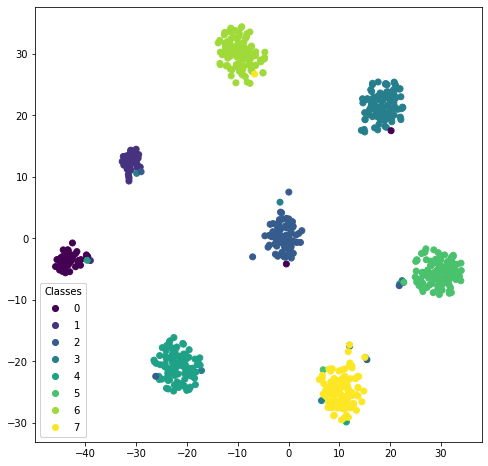

In [58]:
# Compute TSNE for different features and create a scatter plot
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
# xX = get_resnet_features(dirpath)
X = get_lda(X,y,7)
# X =  # feature 
k = 2 # Number of components in TSNE

# Compute
X_TSNE = TSNE(n_components=k).fit_transform(X)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(np.real(X_TSNE[:,0]),np.real(X_TSNE[:,1]),c=y)
# Plot the representation in 2d/3d
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

Dataset shape: (400, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


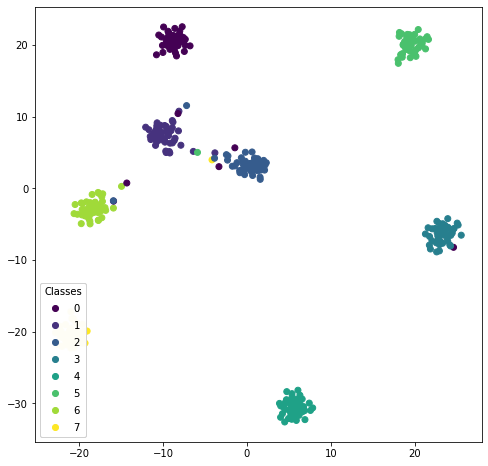

In [59]:
# Compute TSNE for different features and create a scatter plot
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
# X = get_resnet_features(dirpath)
X = get_lda(X,y,7)
# X =  # feature 
k = 2 # Number of components in TSNE

# Compute
X_TSNE = TSNE(n_components=k).fit_transform(X)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(np.real(X_TSNE[:,0]),np.real(X_TSNE[:,1]),c=y)
# Plot the representation in 2d/3d
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

Dataset shape: (165, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


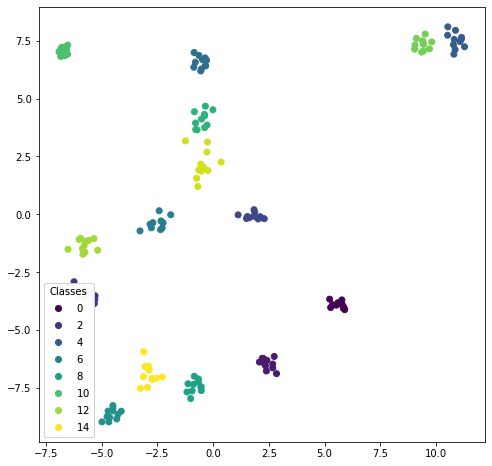

In [60]:
dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
# X = get_resnet_features(dirpath)
X = get_lda(X,y,7)
# X =  # feature 
k = 2 # Number of components in TSNE

# Compute
X_TSNE = TSNE(n_components=k).fit_transform(X)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(np.real(X_TSNE[:,0]),np.real(X_TSNE[:,1]),c=y)
# Plot the representation in 2d/3d
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN

1. Extract one of the given features provided. 
2. Split the dataset into train and validation. 
3. On the validation set, check for each datapoint what its k nearest neighbors are. 
4. Out prediction will be the most number of its nearest neighbours from a class is the datapoints class as well. 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

___________________________________________________________________
Metrics for performace: accuray. But more importantly precision. We have make no mistake if the face is not the correct one. So, even if it is correctbut we are not sure or it is 50-50 we have to reject it. I have extracted and performed KNN on various features but Resnet + KLDA is giving me the best performance.  

4(c)Show empirical results  with  all  the  representations

In [61]:
class FaceVerification():
    def __init__(self,k,classes):
        self.k = k
        self.classes = classes
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        verif = False
        dist = np.zeros(self.X_train.shape[0],)
        cnt = 0
        z=0
        freq = np.zeros(self.classes,)
        sort = np.zeros(self.X_train.shape[0],)
        for j in range(self.X_train.shape[0]): #for every training data 
            dist[z] = np.linalg.norm(self.X_train[j,:]-X[:]) # euclidean distance 
            z = z+1
        sort = np.argsort(dist)
        maxi = 0
        for k in range(self.k):
            freq[int(self.y_train[sort[k]])] += 1
        pred = np.argmax(freq)
        print(pred)
        print(class_id)
        if int(class_id) == int(pred):
            verif = True
#             self.verification_results += 1
        else:
            verif = False
#             self.verification_results = 0
        verfication_results = verif
        return verfication_results
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
            
            @return Nothing
        """
        self.X_train = X_train 
        self.y_train = y_train 
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
#         dist = np.zeros(np.shape(self.X_train[0]),)
        dist = np.zeros(self.X_train.shape[0],)
        cnt = 0
        predlist = []
        for i in range(X_validate.shape[0]):
            z=0
            freq = np.zeros(self.classes,)
            sort = np.zeros(self.X_train.shape[0],)
            for j in range(self.X_train.shape[0]): #for every training data 
                dist[z] = np.linalg.norm(self.X_train[j,:]-X_validate[i,:]) # euclidean distance 
                z = z+1
            sort = np.argsort(dist)
            maxi = 0
            for k in range(self.k):
                freq[int(self.y_train[sort[k]])] += 1
            pred = np.argmax(freq)
            predlist.append(pred)
            if y_validate[i] == pred:
                cnt += 1 
#         acc = (cnt/X_validate.shape[0])
        classification_report = sk.metrics.classification_report(y_validate, predlist)
        return classification_report

In [62]:
# Create a train and validation split and show your results 

# LDA 
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_lda(X,y,7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(np.shape(X_train))
# print(np.shape(X_test))
obj=FaceVerification(9,8)
obj.train(X_train, y_train)
print('IIIT-CFW\n')
print(obj.validate(X_test,y_test))
print('\n')

dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_lda(X,y,7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(np.shape(X_train))
# print(np.shape(X_test))
obj=FaceVerification(9,8)
obj.train(X_train, y_train)
print('IMFDB\n')
print(obj.validate(X_test,y_test))
print('\n')

dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_lda(X,y,7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(np.shape(X_train))
# print(np.shape(X_test))
obj=FaceVerification(9,15)
obj.train(X_train, y_train)
print('Yale Face Database\n')
print(obj.validate(X_test,y_test))
print('\n')

Dataset shape: (672, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


IIIT-CFW

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00        17
           3       1.00      0.91      0.95        11
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        21
           7       0.94      1.00      0.97        16

    accuracy                           0.99       135
   macro avg       0.99      0.99      0.99       135
weighted avg       0.99      0.99      0.99       135



Dataset shape: (400, 32, 32)
IMFDB



/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      1.00      1.00        13
           2       0.92      0.92      0.92        12
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        11
           6       0.85      1.00      0.92        11
           7       1.00      0.83      0.91         6

    accuracy                           0.96        80
   macro avg       0.97      0.95      0.96        80
weighted avg       0.97      0.96      0.96        80



Dataset shape: (165, 32, 32)
Yale Face Database

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         3
           4       1.00    

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [63]:
# Create a train and validation split and show your results 

# PCA
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_pca(X,309)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(np.shape(X_train))
# print(np.shape(X_test))
obj=FaceVerification(9,8)
obj.train(X_train, y_train)
print('IIIT-CFW\n')
print(obj.validate(X_test,y_test))
print('\n')

dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_pca(X,108)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(np.shape(X_train))
# print(np.shape(X_test))
obj=FaceVerification(9,8)
obj.train(X_train, y_train)
print('IMFDB\n')
print(obj.validate(X_test,y_test))
print('\n')

dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_pca(X,62)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(np.shape(X_train))
# print(np.shape(X_test))
obj=FaceVerification(9,15)
obj.train(X_train, y_train)
print('Yale Face Database\n')
print(obj.validate(X_test,y_test))
print('\n')

Dataset shape: (672, 32, 32)
IIIT-CFW

              precision    recall  f1-score   support

           0       0.50      0.33      0.40        12
           1       0.67      0.33      0.44         6
           2       0.18      0.67      0.29        18
           3       0.23      0.39      0.29        18
           4       0.46      0.24      0.32        25
           5       0.33      0.06      0.11        16
           6       0.17      0.07      0.10        15
           7       0.50      0.12      0.19        25

    accuracy                           0.27       135
   macro avg       0.38      0.28      0.27       135
weighted avg       0.36      0.27      0.25       135



Dataset shape: (400, 32, 32)
IMFDB

              precision    recall  f1-score   support

           0       0.44      1.00      0.61         7
           1       0.39      0.78      0.52         9
           2       0.69      0.85      0.76        13
           3       0.33      0.11      0.17         9
 

In [64]:
# Create a train and validation split and show your results 

# Resnet 
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_resnet_features(dirpath)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(np.shape(X_train))
# print(np.shape(X_test))
obj=FaceVerification(9,8)
obj.train(X_train, y_train)
print('IIIT-CFW\n')
print(obj.validate(X_test,y_test))
print('\n')

dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_resnet_features(dirpath)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(np.shape(X_train))
# print(np.shape(X_test))
obj=FaceVerification(9,8)
obj.train(X_train, y_train)
print('IMFDB\n')
print(obj.validate(X_test,y_test))
print('\n')

dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_resnet_features(dirpath)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(np.shape(X_train))
# print(np.shape(X_test))
obj=FaceVerification(9,15)
obj.train(X_train, y_train)
print('Yale Face Database\n')
print(obj.validate(X_test,y_test))
print('\n')

Dataset shape: (672, 32, 32)
IIIT-CFW

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00        12
           3       1.00      0.95      0.98        22
           4       1.00      1.00      1.00        21
           5       0.96      1.00      0.98        23
           6       1.00      0.95      0.98        22
           7       1.00      1.00      1.00        25

    accuracy                           0.99       135
   macro avg       0.97      0.99      0.98       135
weighted avg       0.99      0.99      0.99       135



Dataset shape: (400, 32, 32)
IMFDB

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.75      1.00      0.86         6
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        12
 

In [65]:
# Create a train and validation split and show your results 

# KLDA
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_kernel_lda(X,y,7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(np.shape(X_train))
# print(np.shape(X_test))
obj=FaceVerification(9,8)
obj.train(X_train, y_train)
print('IIIT-CFW\n')
print(obj.validate(X_test,y_test))
print('\n')

dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_kernel_lda(X,y,7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(np.shape(X_train))
# print(np.shape(X_test))
obj=FaceVerification(9,8)
obj.train(X_train, y_train)
print('IMFDB\n')
print(obj.validate(X_test,y_test))
print('\n')

dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_kernel_lda(X,y,7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(np.shape(X_train))
# print(np.shape(X_test))
obj=FaceVerification(9,15)
obj.train(X_train, y_train)
print('Yale Face Database\n')
print(obj.validate(X_test,y_test))
print('\n')

Dataset shape: (672, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


IIIT-CFW

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        19
           6       0.96      1.00      0.98        26
           7       1.00      0.94      0.97        17

    accuracy                           0.99       135
   macro avg       1.00      0.99      0.99       135
weighted avg       0.99      0.99      0.99       135



Dataset shape: (400, 32, 32)
IMFDB



/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.93      0.97        15
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00         4
           4       0.89      0.89      0.89         9
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         9

    accuracy                           0.97        80
   macro avg       0.97      0.98      0.97        80
weighted avg       0.98      0.97      0.98        80



Dataset shape: (165, 32, 32)
Yale Face Database

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       1.00    

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [66]:
# Create a train and validation split and show your results 

# Resnet + KLDA
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_resnet_features(dirpath)
X = get_kernel_lda(X,y,7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(np.shape(X_train))
# print(np.shape(X_test))
obj=FaceVerification(9,8)
obj.train(X_train, y_train)
print('IIIT-CFW\n')
print(obj.validate(X_test,y_test))
print('\n')

dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_resnet_features(dirpath)
X = get_kernel_lda(X,y,7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(np.shape(X_train))
# print(np.shape(X_test))
obj=FaceVerification(9,8)
obj.train(X_train, y_train)
print('IMFDB\n')
print(obj.validate(X_test,y_test))
print('\n')

dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_resnet_features(dirpath)
X = get_kernel_lda(X,y,7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(np.shape(X_train))
# print(np.shape(X_test))
obj=FaceVerification(9,15)
obj.train(X_train, y_train)
print('Yale Face Database\n')
print(obj.validate(X_test,y_test))
print('\n')

Dataset shape: (672, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


IIIT-CFW

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        16
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        19
           7       1.00      1.00      1.00        22

    accuracy                           1.00       135
   macro avg       1.00      1.00      1.00       135
weighted avg       1.00      1.00      1.00       135



Dataset shape: (400, 32, 32)


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


IMFDB

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00         7

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



Dataset shape: (165, 32, 32)
Yale Face Database

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2
           4       1

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [67]:
# Create a train and validation split and show your results 

# VGG 
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_vgg_features(dirpath)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
obj=FaceVerification(9,8)
obj.train(X_train, y_train)
print('IIIT-CFW\n')
print(obj.validate(X_test,y_test))
print('\n')

dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_vgg_features(dirpath)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
obj=FaceVerification(9,8)
obj.train(X_train, y_train)
print('IMFDB\n')
print(obj.validate(X_test,y_test))
print('\n')

dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X = get_vgg_features(dirpath)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
obj=FaceVerification(9,15)
obj.train(X_train, y_train)
print('Yale Face Database\n')
print(obj.validate(X_test,y_test))
print('\n')

Dataset shape: (672, 32, 32)
IIIT-CFW

              precision    recall  f1-score   support

           0       0.46      0.67      0.55         9
           1       1.00      0.27      0.43        11
           2       0.61      0.52      0.56        21
           3       0.85      0.85      0.85        20
           4       0.48      0.53      0.50        19
           5       0.77      0.81      0.79        21
           6       0.94      0.79      0.86        19
           7       0.50      0.73      0.59        15

    accuracy                           0.67       135
   macro avg       0.70      0.65      0.64       135
weighted avg       0.71      0.67      0.67       135



Dataset shape: (400, 32, 32)
IMFDB

              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       0.80      0.62      0.70        13
           2       0.86      0.86      0.86         7
           3       0.89      0.89      0.89         9
 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [68]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print('For IIIT-CFW\n')
df2 = pd.DataFrame({'Features used': ['PCA', 'LDA', 'Resnet','K-LDA', 'Resnet + K-LDA', 'VGG'],
                   'Dimension Space': ['108', '7', '7', '-', '7', '-'],
                   'Classification error': ['0.68', '0.06', '0.01', '0.04', '0.00', '0.33'],
                   'Accuracy': ['0.32','0.94','0.99','0.96', '1.00', '0.67' ], 
                   'F1-Score': ['0.30', '0.93', '0.98', '0.94', '1.00', '0.59']})
print(df2)
print('\n')
print('For IMFDB\n')
df2 = pd.DataFrame({'Features used': ['PCA', 'LDA', 'Resnet','K-LDA', 'Resnet + K-LDA', 'VGG'],
                   'Dimension Space': ['309', '7', '7', '-','7', '-'],
                   'Classification error': ['0.44', '0.03', '0.05', '0.01', '0.00', '0.07'],
                   'Accuracy': ['0.56','0.97','0.95','0.99', '1.00', '0.93' ], 
                   'F1-Score': ['0.54', '0.98', '0.95', '0.98', '1.00', '0.93']})
print(df2)
print('\n')
print('For Yale face database\n')
df2 = pd.DataFrame({'Features used': ['PCA', 'LDA', 'Resnet','K-LDA', 'Resnet + K-LDA', 'VGG'],
                   'Dimension Space': ['62', '7', '7', '-','7','-'],
                   'Classification error': ['0.27', '0.03', '0.00', '0.03', '0.00', '0.48'],
                   'Accuracy': ['0.73','0.97','1.00','0.97', '1.00', '0.52' ], 
                   'F1-Score': ['0.64', '0.97', '1.00', '0.97', '1.00', '0.48']})
print(df2)
print('\n')
# Print the table. (You can use Pandas)

For IIIT-CFW

    Features used Dimension Space Classification error Accuracy F1-Score
0             PCA             108                 0.68     0.32     0.30
1             LDA               7                 0.06     0.94     0.93
2          Resnet               7                 0.01     0.99     0.98
3           K-LDA               -                 0.04     0.96     0.94
4  Resnet + K-LDA               7                 0.00     1.00     1.00
5             VGG               -                 0.33     0.67     0.59


For IMFDB

    Features used Dimension Space Classification error Accuracy F1-Score
0             PCA             309                 0.44     0.56     0.54
1             LDA               7                 0.03     0.97     0.98
2          Resnet               7                 0.05     0.95     0.95
3           K-LDA               -                 0.01     0.99     0.98
4  Resnet + K-LDA               7                 0.00     1.00     1.00
5             VGG       

### Extention / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
        Chose this. I have shown Accuracy, Precision, F1 Scores. I have also shown the confusion matrix below my classification report for further understanding of the data. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly available or even create one by crawling from internet.

In [69]:
# Load data
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))

Dataset shape: (672, 32, 32)


In [70]:
# Define your features
X = get_resnet_features(dirpath)
#splitting data into train and validation 
# for i in range(len(y)):
#     if (y[i]>=0 and y[i]<=2) or y[i]==4:
#         y[i] = 1
#     else:
#         y[i] = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#11101000 [1 is actor 0 is politician]
#changing labels 
for i in range(len(y_train)):
    if (y_train[i]>=0 and y_train[i]<=2) or y_train[i]==4:
        y_train[i] = 1
    else:
        y_train[i] = 0
for i in range(len(y_test)):
    if (y_test[i]>=0 and y_test[i]<=2) or y_test[i]==4:
        y_test[i] = 1
    else:
        y_test[i] = 0

In [71]:
# Create your classifier
# Define your classifier here. You can use libraries like sklearn to create your classifier 
# MLP
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
import sklearn as sk
class E_Classifier():
    def __init__(self, X_train):
#         super.__init__()
        model = Sequential()
        model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))# layer 1 neuron 1000
        model.add(Dense(20, activation='relu'))# layer 2 neuron 1000
        model.add(Dense(1, activation='sigmoid'))# output layer
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model = model
    # Define your parameters eg, W,b, max_iterations etc. 
    def verify(self,X_validate,y_true):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        verif = False
        y_pred = self.model.predict_classes(X_validate[0,:])
        if int(y_true) == int(y_pred):
            verif = True
        else:
            verif = False
        verfication_results = verif
        return verfication_results
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        predict = model.predict(X)
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        confusion_matrix = sk.metrics.confusion_matrix(y, pred)
        return confusion_matrix
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.model.fit(X_train, y_train,epochs=10)
    def retacc(self, X_validate, y_validate):
        y_pred = self.model.predict_classes(X_validate)
        acc = sk.metrics.accuracy_score(y_validate,y_pred)
        return acc
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        y_pred = self.model.predict_classes(X_validate)
        # Create a confusion matrix
        confusion_matrix = self.confusion_matrix(y_pred, y_validate)
        # Calculate Validation accuracy 
        # Calculate precision and recall 
        # Calculate F1-score 
        classification_report = sk.metrics.classification_report(y_validate, y_pred)
        return confusion_matrix, classification_report
# Validate your classifier

In [72]:
obj = E_Classifier(X_train)
obj.train(X_train, y_train)
conf_mat, class_rep = obj.validate(X_test, y_test)
print(class_rep)
print(conf_mat)

Epoch 1/10
537/537 [==============================] - 0s 320us/step - loss: 0.1882 - accuracy: 0.9460
Epoch 2/10
537/537 [==============================] - 0s 66us/step - loss: 0.0415 - accuracy: 0.9888
Epoch 3/10
537/537 [==============================] - 0s 65us/step - loss: 0.0372 - accuracy: 0.9888
Epoch 4/10
537/537 [==============================] - 0s 65us/step - loss: 0.0335 - accuracy: 0.9907
Epoch 5/10
537/537 [==============================] - 0s 66us/step - loss: 0.0320 - accuracy: 0.9870
Epoch 6/10
537/537 [==============================] - 0s 69us/step - loss: 0.0310 - accuracy: 0.9907
Epoch 7/10
537/537 [==============================] - 0s 68us/step - loss: 0.0278 - accuracy: 0.9870
Epoch 8/10
537/537 [==============================] - 0s 62us/step - loss: 0.0314 - accuracy: 0.9870
Epoch 9/10
537/537 [==============================] - 0s 61us/step - loss: 0.0270 - accuracy: 0.9870
Epoch 10/10
537/537 [==============================] - 0s 57us/step - loss: 0.0214 - accur

In [73]:
# Define your features
X = get_resnet_features(dirpath)
#splitting data into train and validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#11101000 [1 is actor 0 is politician]
#changing labels 
for i in range(len(y_train)):
    if (y_train[i]>=0 and y_train[i]<=2) or y_train[i]==4:
        y_train[i] = 1
    else:
        y_train[i] = 0
for i in range(len(y_test)):
    if (y_test[i]>=0 and y_test[i]<=2) or y_test[i]==4:
        y_test[i] = 1
    else:
        y_test[i] = 0
for i in range(len(y)):
    if (y[i]>=0 and y[i]<=2) or y[i]==4:
        y[i] = 1
    else:
        y[i] = 0

In [74]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.
# I have provided accuracy, precision and confusion matrix above. Please look at that. And I am performing K-Fold Validation here 
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf.get_n_splits(X)
acc = []
for train_index, test_index in kf.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     obj = E_Classifier(X_train)
     obj.train(X_train, y_train)
     acc.append(obj.retacc(X_test,y_test))
#      print(obj.retacc(X_test,y_test))
acc = np.array(acc)
print(np.mean(acc))

Epoch 1/10
537/537 [==============================] - 0s 282us/step - loss: 0.1660 - accuracy: 0.9385
Epoch 2/10
537/537 [==============================] - 0s 61us/step - loss: 0.0437 - accuracy: 0.9907
Epoch 3/10
537/537 [==============================] - 0s 61us/step - loss: 0.0446 - accuracy: 0.9851
Epoch 4/10
537/537 [==============================] - 0s 62us/step - loss: 0.0436 - accuracy: 0.9870
Epoch 5/10
537/537 [==============================] - 0s 61us/step - loss: 0.0355 - accuracy: 0.9814
Epoch 6/10
537/537 [==============================] - 0s 56us/step - loss: 0.0330 - accuracy: 0.9888
Epoch 7/10
537/537 [==============================] - 0s 57us/step - loss: 0.0290 - accuracy: 0.9888
Epoch 8/10
537/537 [==============================] - 0s 81us/step - loss: 0.0271 - accuracy: 0.9888
Epoch 9/10
537/537 [==============================] - 0s 72us/step - loss: 0.0260 - accuracy: 0.9888
Epoch 10/10
537/537 [==============================] - 0s 57us/step - loss: 0.0256 - accur

In [75]:
# Show quantitative results such as examples of correct prediction and wrong prediction
# From the confusion matrix we can see that 132 samples have been correctly classified and 3 have been wrongly classified.
# That is the quantitative result.
# Couldnt find an example which is classified wrongly manually cause the classifier's accuracy is so high 